In [2]:
!pip install xgboost joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

In [7]:
from google.colab import files, drive
data_path = '/content/drive/MyDrive/vocal_features.csv'
df = pd.read_csv(data_path)

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

print("\nLabel Distribution:")
print(df['Label'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_name     1224 non-null   object 
 1   task          1224 non-null   object 
 2   pitch_mean    1224 non-null   float64
 3   pitch_std     1224 non-null   float64
 4   pitch_range   1224 non-null   float64
 5   jitter        1224 non-null   float64
 6   shimmer       1224 non-null   float64
 7   formant_f1    1224 non-null   float64
 8   formant_f2    1224 non-null   float64
 9   formant_f3    1224 non-null   float64
 10  hnr           1224 non-null   float64
 11  duration      1224 non-null   float64
 12  mfcc_1_mean   1224 non-null   float64
 13  mfcc_2_mean   1224 non-null   float64
 14  mfcc_3_mean   1224 non-null   float64
 15  mfcc_4_mean   1224 non-null   float64
 16  mfcc_5_mean   1224 non-null   float64
 17  mfcc_6_mean   1224 non-null   float64
 18  mfcc_7_mean   

In [9]:
# Handle missing values (impute with median for numerical features)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Check for and replace infinite values with NaN
df[numerical_cols] = df[numerical_cols].replace([np.inf, -np.inf], np.nan)

# Now impute both original NaNs and newly created NaNs with the median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Encode categorical variables
# Encode 'task' column
task_encoder = LabelEncoder()
df['task_encoded'] = task_encoder.fit_transform(df['task'])
joblib.dump(task_encoder, 'task_encoder.pkl')  # Save encoder

# Encode 'label' column (skip if no label column)
if 'Label' in df.columns:
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['Label'])
    joblib.dump(label_encoder, 'label_encoder.pkl')  # Save encoder
else:
    raise ValueError("Label column missing. Please provide label data.")

# Define features (exclude non-feature columns)
feature_cols = [col for col in df.columns if col not in ['file_name', 'task', 'Label', 'label_encoded']]
X = df[feature_cols]
y = df['label_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')  # Save scaler

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

Training set shape: (979, 37)
Testing set shape: (245, 37)


In [11]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model
    }

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}, CV Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Convert label_encoder classes to strings to avoid TypeError in classification_report
    target_class_names = [str(c) for c in label_encoder.classes_]
    print(f"Classification Report:\n{classification_report(y_test, y_pred, target_names=target_class_names)}")


Training Random Forest...
Random Forest - Test Accuracy: 0.9837, CV Mean Accuracy: 0.9785 ± 0.0119
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       119
           1       1.00      0.97      0.98       126

    accuracy                           0.98       245
   macro avg       0.98      0.98      0.98       245
weighted avg       0.98      0.98      0.98       245


Training SVM...
SVM - Test Accuracy: 0.9796, CV Mean Accuracy: 0.9744 ± 0.0130
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       119
           1       0.98      0.98      0.98       126

    accuracy                           0.98       245
   macro avg       0.98      0.98      0.98       245
weighted avg       0.98      0.98      0.98       245


Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:59:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:59:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:59:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:59:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:59:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost - Test Accuracy: 0.9837, CV Mean Accuracy: 0.9765 ± 0.0144
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       119
           1       1.00      0.97      0.98       126

    accuracy                           0.98       245
   macro avg       0.98      0.98      0.98       245
weighted avg       0.98      0.98      0.98       245



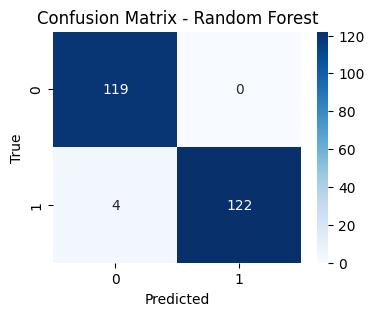

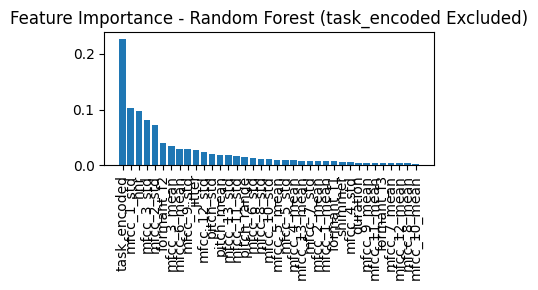

In [17]:
# Confusion Matrix for the best model (based on F1-score)
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']
y_pred_best = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# Feature Importance (for Random Forest or XGBoost)
if best_model_name in ['Random Forest', 'XGBoost']:
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(4, 3))
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_cols[i] for i in indices], rotation=90)
    plt.title(f'Feature Importance - {best_model_name} (task_encoded Excluded)')
    plt.tight_layout()
    plt.savefig('feature_importance_no_task.png')
    plt.show()

In [13]:
# Save the best model
joblib.dump(best_model, f'best_model_{best_model_name.lower().replace(" ", "_")}.pkl')
print(f"Best model ({best_model_name}) saved as 'best_model_{best_model_name.lower().replace(' ', '_')}.pkl'")

# Download saved files
files.download(f'best_model_{best_model_name.lower().replace(" ", "_")}.pkl')
files.download('task_encoder.pkl')
files.download('label_encoder.pkl')
files.download('scaler.pkl')
files.download('model_performance.png')
files.download('confusion_matrix.png')
if best_model_name in ['Random Forest', 'XGBoost']:
    files.download('feature_importance.png')

Best model (Random Forest) saved as 'best_model_random_forest.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>